In [3]:
import zipfile
import scipy.io
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import mne
import torch
import scipy.stats as stats
from torchvision import datasets, transforms

## Test the model

In [2]:
import sys
sys.path.insert(0,'/scratch/mcesped/code/NoiseDetection_iEEG/interictal_classifier/')

from model import IeegClassifier

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = IeegClassifier(n_classes=4).to(device)
model_1

IeegClassifier(
  (cnn_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(64, 128, kernel_size=(22, 1), stride=(1, 1), padding=(0, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GRU(128, 64, batch_first=True)
    (3): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [5]:
# Get 1 image
import data_setup

zip_files = ['/home/mcesped/scratch/Datasets/Dataset_Fnusa_np.zip', '/home/mcesped/scratch/Datasets/Dataset_Mayo_np.zip']
df_train, df_val = data_setup.get_train_val_sets(zip_files)

test_transform = transforms.Compose([
    transforms.Resize((100, 100))
])

train_data_custom = data_setup.ImageFolderCustom(df=df_train, zip_files=zip_files, transform=test_transform)

data, target = train_data_custom[9109]
data.shape, target

(3600,)


/local/mcesped.13739801.0/tmp/kslurm-venv-dtl_fvvn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([1, 100, 100]), 1)

In [6]:
data.type(), data.shape

('torch.DoubleTensor', torch.Size([1, 100, 100]))

In [7]:
# Now test inferance mode 
model_1.eval()
custom_data = data.unsqueeze(dim=0).type(torch.float)
print(custom_data.shape)
with torch.inference_mode():
    model_1(custom_data.to(device))

torch.Size([1, 1, 100, 100])
torch.Size([1, 64, 22, 22])
torch.Size([1, 4])


## Train val split

In [59]:
with zipfile.ZipFile(inputZip, mode="a") as archive:
    archive.write('segments_new_Fnusa.csv','DATASET_FNUSA/segments_new.csv')

In [2]:
df_new = pd.read_csv('segments_new.csv', sep=',', index_col='index')

In [3]:
df_new.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,None,1,LMacro_01,depth,mayo,0,3,x000000,1,noise
1,None,1,LMacro_01,depth,mayo,0,1,x000001,1,noise
2,None,1,LMacro_01,depth,mayo,0,3,x000002,1,noise
3,None,1,LMacro_01,depth,mayo,0,3,x000003,1,noise
4,None,1,LMacro_01,depth,mayo,0,1,x000004,1,noise


In [46]:
def train_val_split(df, val_split=0.3, margin_allowance = 0.02):
    # List of percentages by subj
    percentages_list = []
    for id_subj in np.unique(df['patient_id']):
        percentages_list.append(len(df[df['patient_id']==id_subj])/len(df))
    # Zip with patients id
    percentages = np.vstack([percentages_list, np.unique(df['patient_id'])])
    val_real = 0
    val_subj = []
    cond = False
    while cond == False:
        # Look for all the percentages lower than val
        mask = percentages[0,:]<val_split-val_real
        percentages_eval = percentages[:,mask]
        if percentages_eval.size!=0:
            # Get the bigger value 
            new_val_id = percentages_eval[0,:].argmax()
            if val_split+margin_allowance >= val_real+percentages_eval[0,:].max(): #%2 margin
                val_real += percentages_eval[0,:].max()
                # add val subj
                val_subj.append(int(percentages_eval[1,new_val_id]))
                # Delete the value from array
                indexes = np.arange(percentages.shape[-1])
                percentages = np.delete(percentages, indexes[mask][new_val_id], axis=-1)
            else:
                cond = True
        else:
            cond = True
    # Get train subj
    train_subj = percentages[1,:].astype(int)
    train_real = 1-val_real
    
    return [(train_subj, train_real), (val_subj, val_real)]

In [47]:
def train_val_split_multiclass(df, val_split=0.3, margin_allowance = 0.02, class_col='institution'):
    df_val = []
    df_train = []
    for id_class in np.unique(df[class_col]):
        df_class = df[df[class_col]==id_class]
        # Run train val split
        (train_subj, _), (val_subj, _) = train_val_split(df_class, val_split, margin_allowance)
        # Add train subj df
        for subj in train_subj:
            if len(df_train)==0:
                df_train = df_class[df_class['patient_id']==subj]
            else:
                df_train = pd.concat([df_train, df_class[df_class['patient_id']==subj]])
        # Add val subj df
        for subj in val_subj:
            if len(df_val)==0:
                df_val = df_class[df_class['patient_id']==subj]
            else:
                df_val = pd.concat([df_val, df_class[df_class['patient_id']==subj]])
    
    return df_train, df_val

In [60]:
(train_subj, train_real), (val_subj, val_real) = train_val_split(df_new, val_split=0.3)
print(train_subj, train_real)
print(val_subj, val_real)

[ 0  1  2  3  4  5  6  7  8  9 10 13] 0.7018869292349755
[12, 11] 0.29811307076502447


- Mayo results

[ 0  1  2  3  4  5  6  8 10 11 13 14 15 16 17 18 19 20 21 22 23] 0.7000811949839543

[7, 12, 9] 0.2999188050160457

- Fnusa

[ 0  1  2  3  4  5  6  7  8  9 10 13] 0.7018869292349755

[12, 11] 0.29811307076502447

## Combine data

In [7]:
# Initialize variables
df_total = []
files = []
map_zip_to_inst = dict()

zip_files = ['/home/mcesped/scratch/Datasets/Dataset_Fnusa.zip', '/home/mcesped/scratch/Datasets/Dataset_Mayo.zip']
for zip_id, zip_file in enumerate(zip_files):
    with zipfile.ZipFile(zip_file, mode="r") as f:
        # Get all files
        files_zip = f.namelist()
        files.append(files_zip) #Save files
        # Find segments.csv
        reg = re.compile("segments_new.csv")
        seg_path= list(filter(reg.search, files_zip))[0]
        # Get df
        with f.open(seg_path) as myfile:
            df = pd.read_csv(myfile, sep=',', index_col='index')
            # Add the mapping
            for inst in  np.unique(df['institution']):
                map_zip_to_inst[inst] = zip_id
            # Append df
            if len(df_total)==0:
                df_total = df
            else:
                df_total = pd.concat([df_total, df])

In [3]:
map_zip_to_inst

{'fnusa': 0, 'mayo': 1}

In [4]:
df_total.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,gyrus lingualis,0,D1,depth,fnusa,0,1,y000000,0,powerline
1,gyrus lingualis,0,D1,depth,fnusa,0,1,y000001,0,powerline
2,gyrus lingualis,0,D1,depth,fnusa,0,1,y000002,0,powerline
3,gyrus lingualis,0,D1,depth,fnusa,0,1,y000003,0,powerline
4,gyrus lingualis,0,D1,depth,fnusa,0,1,y000004,0,powerline


In [5]:
df_total.loc[(df_total['institution']=='fnusa').astype(bool) & (df_total['patient_id']==0).astype(bool)]

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,gyrus lingualis,0,D1,depth,fnusa,0,1,y000000,0,powerline
1,gyrus lingualis,0,D1,depth,fnusa,0,1,y000001,0,powerline
2,gyrus lingualis,0,D1,depth,fnusa,0,1,y000002,0,powerline
3,gyrus lingualis,0,D1,depth,fnusa,0,1,y000003,0,powerline
4,gyrus lingualis,0,D1,depth,fnusa,0,1,y000004,0,powerline
...,...,...,...,...,...,...,...,...,...,...
7127,precuneus,0,R3,depth,fnusa,0,1,y007127,0,powerline
7128,precuneus,0,R3,depth,fnusa,0,1,y007128,0,powerline
7129,precuneus,0,R3,depth,fnusa,0,1,y007129,0,powerline


In [6]:
df_train, df_val = train_val_split_multiclass(df_total, val_split=0.3, margin_allowance = 0.02, class_col='institution')

NameError: name 'train_val_split_multiclass' is not defined

In [ ]:
df_train.loc[df_train['category_name']=='physiology']

In [ ]:
df_train.iloc[10000]

In [ ]:
# Check size
len(df_train)/len(df_total), len(df_val)/len(df_total)

In [ ]:
# Check subjs
for df in (df_train, df_val):
    for inst in np.unique(df['institution']):
        df_inst = df[df['institution']==inst]
        print('Institution: ',inst)
        print('Subjects: ',np.unique(df_inst['patient_id']))
    print('\n')

## Testing Dataset class

In [2]:
import sys
sys.path.insert(0,'/scratch/mcesped/code/NoiseDetection_iEEG/interictal_classifier/')

import custom_dataset

In [3]:
zip_files = ['/home/mcesped/scratch/Datasets/Dataset_Fnusa_np.zip', '/home/mcesped/scratch/Datasets/Dataset_Mayo_np.zip']
df_train, df_val = custom_dataset.get_train_val_sets(zip_files)
df_train.head()

,index,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
0,0,gyrus lingualis,0,D1,depth,fnusa,0,1,y000000,0,powerline
1,1,gyrus lingualis,0,D1,depth,fnusa,0,1,y000001,0,powerline
2,2,gyrus lingualis,0,D1,depth,fnusa,0,1,y000002,0,powerline
3,3,gyrus lingualis,0,D1,depth,fnusa,0,1,y000003,0,powerline
4,4,gyrus lingualis,0,D1,depth,fnusa,0,1,y000004,0,powerline


In [4]:
df_test = df_val
for inst in np.unique(df_test['institution']):
    df_inst = df_test#.loc[df_test['institution']==inst]
    # print(df_inst.head())
    print(np.unique(df_inst['patient_id']),np.unique(df_inst['category_id'], return_counts=True))

[ 7  9 11 12] (array([0, 1, 2, 3]), array([19851,  5422, 11782, 67058]))
[ 7  9 11 12] (array([0, 1, 2, 3]), array([19851,  5422, 11782, 67058]))


In [5]:
len(df_val[df_val['category_name']=='pathology'])

11782

In [14]:
train_labels = df_val.category_id.to_numpy()
# Probability per class
class_sample_counts = np.unique(train_labels, return_counts=True)[1]
cls_weights = (1 / torch.Tensor(class_sample_counts))
class_sample_counts

array([19851,  5422, 11782, 67058])

In [67]:
df_train[df_train['category_name']=='powerline'][20000:20050]

,index,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
189850,100845,Left-Cerebral-White-Matter,0,LAD_1,depth,mayo,13,1,x100845,0,powerline
189851,100846,Left-Cerebral-White-Matter,0,LAD_1,depth,mayo,13,1,x100846,0,powerline
189852,100847,Left-Cerebral-White-Matter,0,LAD_1,depth,mayo,13,1,x100847,0,powerline
189853,100848,Left-Cerebral-White-Matter,0,LAD_1,depth,mayo,13,3,x100848,0,powerline
189854,100849,Left-Cerebral-White-Matter,0,LAD_1,depth,mayo,13,3,x100849,0,powerline
189855,100850,Left-Cerebral-White-Matter,0,LAD_1,depth,mayo,13,1,x100850,0,powerline
189856,100851,Left-Cerebral-White-Matter,0,LAD_1,depth,mayo,13,1,x100851,0,powerline
189857,100852,Left-Cerebral-White-Matter,0,LAD_1,depth,mayo,13,3,x100852,0,powerline
189858,100853,Left-Cerebral-White-Matter,0,LAD_1,depth,mayo,13,3,x100853,0,powerline
189859,100854,Left-Cerebral-White-Matter,0,LAD_1,depth,mayo,13,1,x100854,0,powerline


In [4]:
train_data_custom = custom_dataset.MultiLevelSpectrogram(df=df_train, zip_files=zip_files)

In [6]:
print(train_data_custom.files[0][0:2])
print(train_data_custom.inst_to_zipID)
print(train_data_custom.zip_files)
print(train_data_custom.classes, train_data_custom.class_to_idx)

['Dataset_Fnusa/', 'Dataset_Fnusa/segments_new.csv']
{'fnusa': 0, 'mayo': 1}
['/home/mcesped/scratch/Datasets/Dataset_Fnusa_np.zip', '/home/mcesped/scratch/Datasets/Dataset_Mayo_np.zip']
['noise', 'pathology', 'physiology', 'powerline'] {'noise': 1, 'pathology': 2, 'physiology': 3, 'powerline': 0}


In [7]:
len(train_data_custom)

244187

In [8]:
len(train_data_custom), len(df_train)

(244187, 244187)

In [5]:
# Test get_item
# physiology 10002, 151100
# noise 244173, 150100
# pathology 10200, 150000
# powerline 10, 240032
data, target = train_data_custom[112]
data.shape, target

((3600,), 0)

In [27]:
data_spec.shape

(513, 27)

In [28]:
np.random.random()

0.570115058118296

In [14]:
# Custom transform
class RandomMask(object):
    """Masks randomly the spectrogram in a sample.
    3 masks in freq and 2 in time. 
    https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-022-01942-2

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, p: float, f_max_size: int = 10, t_max_size: int=0, n_masks_f: int = 3, n_masks_t: int = 3):
        assert isinstance(p, (float)) & (p <=1) & (p>=0)
        self.p = p
        self.f_max = f_max_size
        self.t_max = t_max_size
        self.n_masks_f = n_masks_f
        self.n_masks_t = n_masks_t

    def __call__(self, image):
        # print(image.shape)
        h, w = image.shape[-2:]

        image_out = torch.tensor(image)
        # Execute given a certain probability
        if np.random.random() < self.p:
            # Masks in freq 
            for i in range(self.n_masks_f):
                # Mask goes from f_0 to f_0+f
                f = np.random.randint(low=0.0, high=self.f_max, size=1)[0]
                f_0 = np.random.randint(low=0.0, high=h-f, size=1)[0]
                # Update image
                image_out[:,f_0:f_0+f,:] = 0.0
            # Masks in time 
            for i in range(self.n_masks_t):
                # Mask goes from t_0 to t_0+t
                t = np.random.randint(low=0.0, high=self.t_max, size=1)[0]
                t_0 = np.random.randint(low=0.0, high=w-t, size=1)[0]
                # print(t_0,t)
                # Update image
                image_out[:,:,t_0:t_0+t] = 0.0

        return image_out

In [15]:
from torchvision import datasets, transforms
import torch
train_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(p=1),
    RandomMask(p=0.5),
])

test_transform = transforms.Compose([
    transforms.Resize((100, 100))
])

In [20]:
data.shape

torch.Size([1, 118, 3600])

In [41]:
train_data = train_transforms(data)
# test_data = test_transform(data)

69
85
16


/tmp/ipykernel_22206/2158241855.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_out = torch.tensor(image)


In [48]:
# train_data[:,69:75,:]

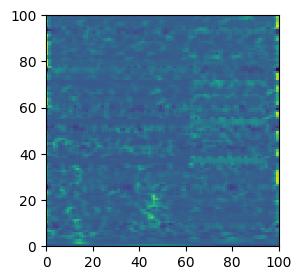

In [49]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,3))
ax.pcolormesh(train_data.numpy().squeeze())

# ax[1].pcolormesh(test_data.numpy().squeeze())

In [52]:
# Reload dataset with transform
train_data_transformed = custom_dataset.ImageFolderCustom(df=df_train, zip_files=zip_files, transform=test_transform)

In [10]:
train_data_transformed.classes

['noise', 'pathology', 'physiology', 'powerline']

torch.Size([1, 100, 100]) 2


/local/mcesped.15309815.0/tmp/kslurm-venv-lln0ipph/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


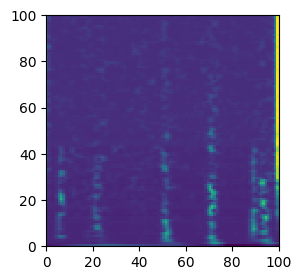

In [66]:
data, target = train_data_transformed[26155]
print(data.shape, target)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,3))
ax.pcolormesh(data.numpy().squeeze())

In [65]:
df_train[df_train['category_id']==2][4000:4050]

,index,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
26149,26149,amygdala,2,A2,depth,fnusa,3,1,y026149,1,pathology
26150,26150,amygdala,2,A2,depth,fnusa,3,1,y026150,1,pathology
26151,26151,amygdala,2,A2,depth,fnusa,3,1,y026151,1,pathology
26152,26152,amygdala,2,A2,depth,fnusa,3,1,y026152,1,pathology
26153,26153,amygdala,2,A2,depth,fnusa,3,1,y026153,1,pathology
26154,26154,amygdala,2,A2,depth,fnusa,3,1,y026154,1,pathology
26155,26155,amygdala,2,A2,depth,fnusa,3,1,y026155,1,pathology
26156,26156,amygdala,2,A2,depth,fnusa,3,1,y026156,1,pathology
26157,26157,amygdala,2,A2,depth,fnusa,3,1,y026157,1,pathology
26158,26158,amygdala,2,A2,depth,fnusa,3,1,y026158,1,pathology


### Test random sampler


In [5]:
df_train.head()

,index,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
0,0,gyrus lingualis,0,D1,depth,fnusa,0,1,y000000,0,powerline
1,1,gyrus lingualis,0,D1,depth,fnusa,0,1,y000001,0,powerline
2,2,gyrus lingualis,0,D1,depth,fnusa,0,1,y000002,0,powerline
3,3,gyrus lingualis,0,D1,depth,fnusa,0,1,y000003,0,powerline
4,4,gyrus lingualis,0,D1,depth,fnusa,0,1,y000004,0,powerline


In [6]:
train_labels = df_train.category_id.to_numpy()
# Probability per class
class_sample_counts = np.unique(train_labels, return_counts=True)[1]
cls_weights = (1 / torch.Tensor(class_sample_counts))
# Map back to elements
weights = cls_weights[train_labels]
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(train_labels), replacement=True)

In [8]:
np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3]), array([35560, 68480, 55915, 84232]))

## Test multilevel class

In [4]:
train_data_custom = custom_dataset.MultiLevelSpectrogram(df=df_train, zip_files=zip_files)

In [5]:
# Test get_item
# physiology 10002, 151100
# noise 244173, 150100
# pathology 10200, 150000
# powerline 10, 240032
data, target = train_data_custom[10002]
data.shape, target

((6144,), 3)

In [113]:
# Did this when I was returning the signal, not spectrogram
tf, freq = custom_dataset.compute_wavelet_transform(data)
t = np.arange(len(data))/1200
tf.shape, freq.shape, t.shape
# from scipy import stats
# plt.pcolormesh(stats.zscore(data_spec.squeeze(), axis=1))

((118, 3600), (118,), (3600,))

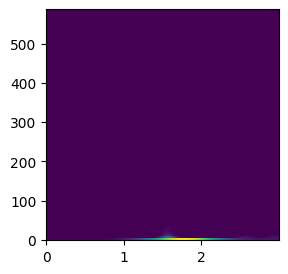

In [102]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,3))
ax.pcolormesh(t, freq, tf)

# ax[1].pcolormesh(test_data.numpy().squeeze())

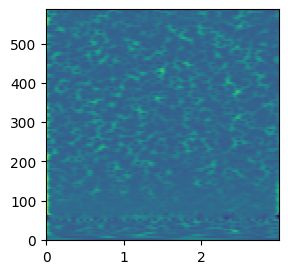

In [81]:
# Previous z-score map
import scipy.stats as stats
image= stats.zscore(tf, axis=1)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,3))

ax.pcolormesh(t, freq,image)

In [146]:
from torchvision import datasets, transforms
import torch
train_transforms = transforms.Compose([
    transforms.Resize((30, 100)),
    transforms.RandomHorizontalFlip(p=1),
    # RandomMask(p=0.5),
])

In [147]:
# New approach 
bands = [(20,100), (80,200), (200,400), (400,600)]
images = torch.zeros(8,30,100)
images_numpy = []
freqs = []
for i, (low_freq, high_freq) in enumerate(bands):
    # Get data in this range
    low_freq_id = np.argmin(np.abs(freq-low_freq))
    high_freq_id = np.argmin(np.abs(freq-high_freq))
    tf_band = tf[low_freq_id:high_freq_id+1,:]
    # Convert to tensor to apply tfms
    tf_band_tensor = np.expand_dims(tf_band, axis=0)
    tf_band_tensor = train_transforms(torch.from_numpy(tf_band_tensor)).squeeze()
    # Z-score freq
    zscore_freq = stats.zscore(tf_band, axis=1)
    images_numpy.append(zscore_freq)
    zscore_freq_torch = stats.zscore(tf_band_tensor.detach().numpy(), axis=1)
    images[i*(2),:,:] = torch.from_numpy(zscore_freq_torch)
    freqs.append(freq[low_freq_id:high_freq_id+1])
    # Z-score time
    zscore_time = stats.zscore(tf_band, axis=0)
    images_numpy.append(zscore_time)
    zscore_time_torch = stats.zscore(tf_band_tensor.detach().numpy(), axis=0)
    images[i*(2)+1,:,:] = torch.from_numpy(zscore_time_torch)
    freqs.append(freq[low_freq_id:high_freq_id+1])

In [ ]:
# New approach 
bands = [(20,100), (80,200), (200,400), (400,600)]
images = torch.zeros(8,30,100)
images_numpy = []
freqs = []
for i, (low_freq, high_freq) in enumerate(bands):
    # Get data in this range
    low_freq_id = np.argmin(np.abs(freq-low_freq))
    high_freq_id = np.argmin(np.abs(freq-high_freq))
    tf_band = tf[low_freq_id:high_freq_id+1,:]
    # Convert to tensor to apply tfms
    tf_band_tensor = np.expand_dims(tf_band, axis=0)
    tf_band_tensor = train_transforms(torch.from_numpy(tf_band_tensor)).squeeze()
    # Z-score freq
    zscore_freq = stats.zscore(tf_band, axis=1)
    images_numpy.append(zscore_freq)
    zscore_freq_torch = stats.zscore(tf_band_tensor.detach().numpy(), axis=1)
    images[i*(2),:,:] = torch.from_numpy(zscore_freq_torch)
    freqs.append(freq[low_freq_id:high_freq_id+1])
    # Z-score time
    zscore_time = stats.zscore(tf_band, axis=0)
    images_numpy.append(zscore_time)
    zscore_time_torch = stats.zscore(tf_band_tensor.detach().numpy(), axis=0)
    images[i*(2)+1,:,:] = torch.from_numpy(zscore_time_torch)
    freqs.append(freq[low_freq_id:high_freq_id+1])

(17, 3600)
(17, 3600)
(25, 3600)
(25, 3600)
(41, 3600)
(41, 3600)
(38, 3600)
(38, 3600)


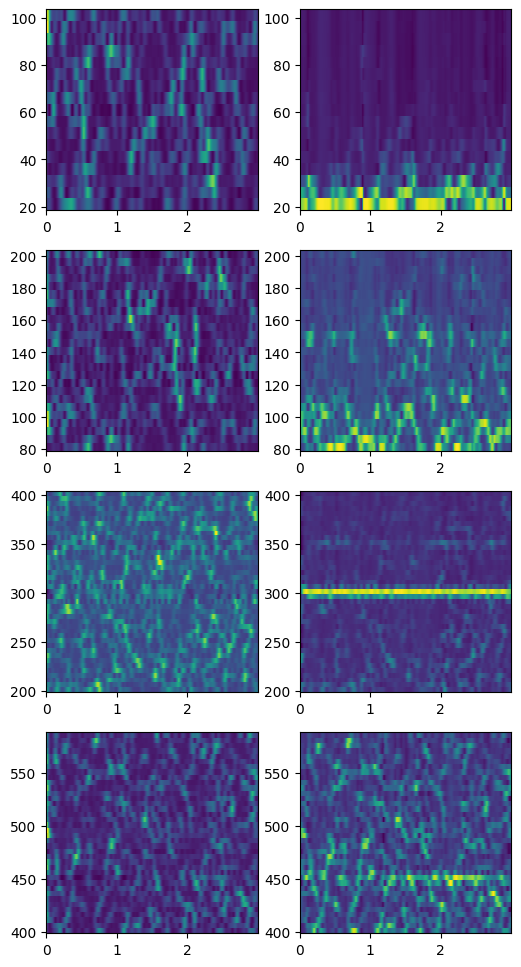

In [148]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(6,12))
for ax, image, freq_scale in zip(axes.flat, images_numpy, freqs):
    ax.pcolormesh(t, freq_scale, image)
    print(image.shape)

(38, 3600)
(38, 3600)
(38, 3600)
(38, 3600)
(38, 3600)
(38, 3600)
(38, 3600)
(38, 3600)


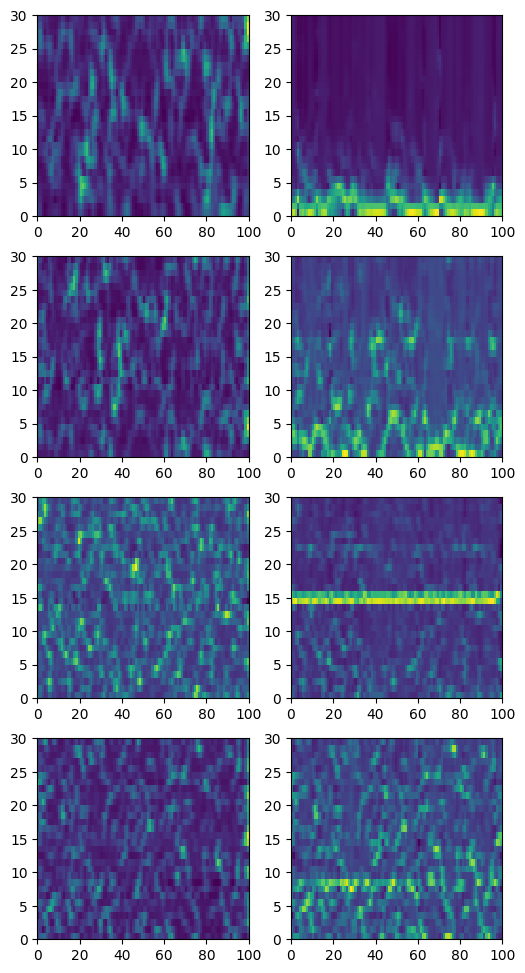

In [149]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(6,12))
for i, (ax, freq_scale) in enumerate(zip(axes.flat, freqs)):
    # image_torch = torch.from_numpy(np.expand_dims(image, axis=0))
    # ax.pcolormesh(train_transforms(image_torch).squeeze())
    ax.pcolormesh(images[i,:,:])
    print(image.shape)

In [29]:
# Custom transform
class RandomMask(object):
    """Masks randomly the spectrogram in a sample.
    3 masks in freq and 2 in time.
    https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-022-01942-2

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(
        self,
        p: float,
        f_max_size: int = 10,
        t_max_size: int = 10,
        n_masks_f: int = 3,
        n_masks_t: int = 3,
    ):
        assert isinstance(p, (float,int)) & (p <= 1) & (p >= 0)
        self.p = p
        self.f_max = f_max_size
        self.t_max = t_max_size
        self.n_masks_f = n_masks_f
        self.n_masks_t = n_masks_t

    def __call__(self, image):
        # print(image.shape)
        h, w = image.shape[-2:]

        image_out = np.copy(image)
        # Execute given a certain probability
        if np.random.random() < self.p:
            # Masks in freq
            for i in range(self.n_masks_f):
                # Mask goes from f_0 to f_0+f
                f = np.random.randint(low=0.0, high=self.f_max, size=1)[0]
                f_0 = np.random.randint(low=0.0, high=h - f, size=1)[0]
                # Update image
                image_out[:, f_0 : f_0 + f, :] = 0.0
            # Masks in time
            for i in range(self.n_masks_t):
                # Mask goes from t_0 to t_0+t
                t = np.random.randint(low=0.0, high=self.t_max, size=1)[0]
                t_0 = np.random.randint(low=0.0, high=w - t, size=1)[0]
                # print(t_0,t)
                # Update image
                image_out[:, :, t_0 : t_0 + t] = 0.0

        return torch.from_numpy(image_out).type(torch.float)

In [30]:
# Test class
from torchvision import datasets, transforms
import torch
train_transforms = transforms.Compose([
    transforms.Resize((30, 100), antialias=True),
    transforms.RandomHorizontalFlip(p=1),
    RandomMask(p=1, f_max_size= 3, t_max_size = 3),
])
train_data_custom = custom_dataset.MultiLevelSpectrogram(df=df_train, zip_files=zip_files, transform=train_transforms)

In [31]:
data, target = train_data_custom[10002]
data.shape, target

(torch.Size([8, 30, 100]), 3)

torch.Size([8, 30, 100])
torch.Size([8, 30, 100])
torch.Size([8, 30, 100])
torch.Size([8, 30, 100])
torch.Size([8, 30, 100])
torch.Size([8, 30, 100])
torch.Size([8, 30, 100])
torch.Size([8, 30, 100])


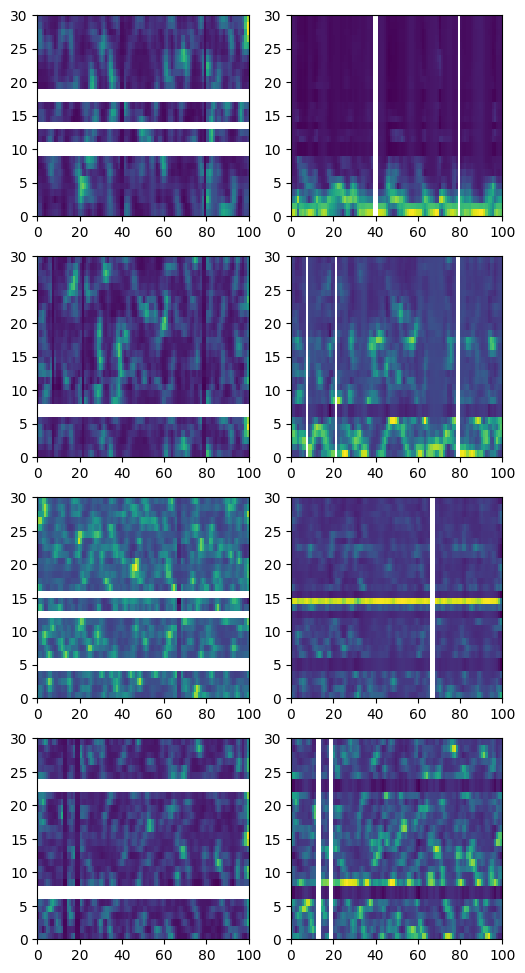

In [32]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(6,12))
for i, ax in enumerate(axes.flat):
    # image_torch = torch.from_numpy(np.expand_dims(image, axis=0))
    # ax.pcolormesh(train_transforms(image_torch).squeeze())
    ax.pcolormesh(data[i,:,:])
    print(data.shape)

### Test bandpass filtering

In [51]:
# Test get_item
# physiology 10002, 151100
# noise 244173, 150100
# pathology 10200, 150000
# powerline 10, 240032
data, target = train_data_custom[10200]
data.shape, target

((6144,), 2)

In [53]:
info = mne.create_info(['a'], ch_types='seeg', sfreq=2048)
# Create raw
raw = mne.io.RawArray(data.reshape(1,-1)/10000, info, verbose='ERROR')

In [61]:
from torchvision import datasets, transforms
import torch
train_transforms = transforms.Compose([
    transforms.Resize((200, 200), antialias=True),
    # transforms.RandomHorizontalFlip(p=1),
    # RandomMask(p=0.5),
])

In [65]:
# Bandpass filtering with diff bands
bands = [(20,100), (80,250), (200,600), (500,900), (900, None)]
images = torch.zeros(6,200,200)
images_numpy = []
freqs = []
# Compute full transform and z-score per freq
tf, freq = custom_dataset.compute_wavelet_transform(data, srate=2048, min_freq = 1, max_freq=1000)
tf_pytorch = np.expand_dims(tf, axis=0)
tf_pytorch = train_transforms(torch.from_numpy(tf_pytorch)).squeeze()
# Z-score freq
zscore_freq = stats.zscore(tf, axis=1)
images_numpy.append(zscore_freq)
zscore_freq_torch = stats.zscore(tf_pytorch.detach().numpy(), axis=1)
images[0,:,:] = torch.from_numpy(zscore_freq_torch)
freqs.append(freq)
# Now time wise
for i, (low_freq, high_freq) in enumerate(bands):
    new_raw = raw.copy().filter(l_freq=low_freq, h_freq=high_freq, verbose='ERROR')
    new_data = new_raw.get_data().squeeze()*10000
    # Compute wavelet transform
    tf, freq = custom_dataset.compute_wavelet_transform(new_data, srate=2048, min_freq = 1, max_freq=1000)
    # Convert to tensor to apply tfms
    tf_pytorch = np.expand_dims(tf, axis=0)
    tf_pytorch = train_transforms(torch.from_numpy(tf_pytorch)).squeeze()
    # Z-score time
    zscore_time = stats.zscore(tf, axis=0)
    images_numpy.append(zscore_time)
    zscore_time_torch = stats.zscore(tf_pytorch.detach().numpy(), axis=0)
    images[i+1,:,:] = torch.from_numpy(zscore_time_torch)
    freqs.append(freq)

(200, 6144)
(200, 6144)
(200, 6144)
(200, 6144)
(200, 6144)
(200, 6144)


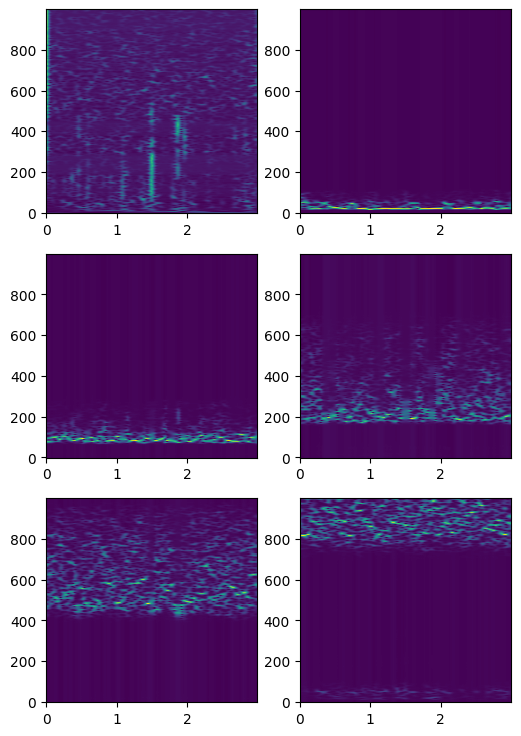

In [67]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(6,9))
t = np.arange(len(data))/2048
for ax, image, freq_scale in zip(axes.flat, images_numpy, freqs):
    ax.pcolormesh(t, freq_scale, image)
    print(image.shape)

torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200, 200])


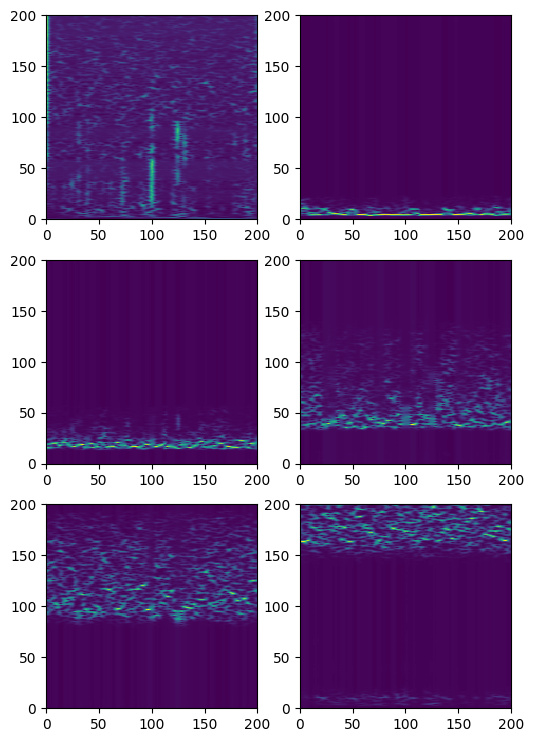

In [68]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(6,9))
t = np.arange(len(data))/2048
for ax, image in zip(axes.flat, images):
    ax.pcolormesh(image)
    print(image.shape)

In [19]:
images_numpy[0][50,:]

array([ 0.98652643,  0.98630041,  0.98568431, ..., 11.2072664 ,
       11.21318272, 11.21516741])

In [18]:
freq[50]

251

## Test wavelet transform

Recovered from: https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/ 

In [53]:
data.numpy().squeeze()

array([-0.00182927, -0.05020337, -0.04130486, ..., -0.01886664,
        0.00407801,  0.00020733])

#### Plot wavelet

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


200 46.72038800000001
2400


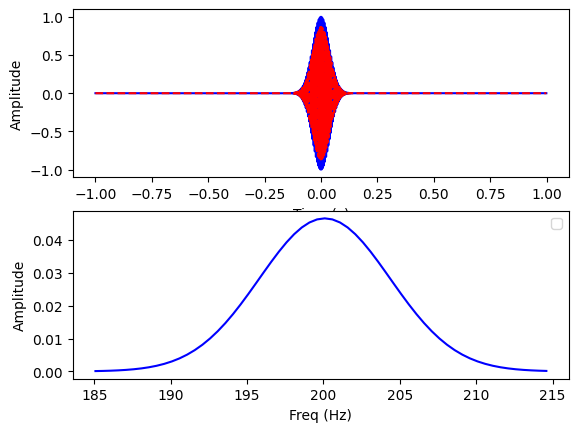

In [154]:
from scipy.fft import fft
# setup parameters
srate = 1200         # in hz
time  = np.arange(-1,1, 1/srate) # best practice is to have time=0 at the center of the wavelet
frex_range  = np.arange(0,590,10)        # frequency of wavelet, in Hz
nCycles_range = np.logspace(np.log10(5), np.log10(150), len(frex_range)) 

i = 20
frex = frex_range[i]
nCycles = 0.0000363292 * frex**2 + 0.215155*frex + 2.23622 
print(frex, nCycles)


# create sine wave (actually cosine, just to make it nice and symmetric)
sine_wave = np.exp( 1j*2*np.pi*frex*time )

# create Gaussian window
# define s
# s = 0.12732395447351627 # 8 cycles in 10 Hz
# print('nCycles', s*(2*np.pi*frex))
s = nCycles/(2*np.pi*frex)
gaus_win = np.exp(-time**2/(2*s**2));

# now create Morlet wavelet
cmw = np.multiply(sine_wave, gaus_win)

fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].plot(time, np.real(cmw), 'b', label='real part')
ax[0].plot(time, np.imag(cmw), '--r', label='img part')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

# Freq domain
pnts = len(time);

mwX = np.abs(fft( cmw )/pnts);
hz  = np.linspace(0,srate,pnts);
print(len(hz))

ax[1].plot(hz[max(2*frex-30, 0):2*frex+30], mwX[max(2*frex-30, 0):2*frex+30], 'b')
# ax[1].plot(hz[150:180], mwX[150:180], 'b')
# ax[1].plot(hz, mwX, 'b')
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('Amplitude')
plt.legend()
plt.show()

In [56]:
import scipy.fft as scifft
import scipy.stats as stats

# variable number of wavelet cycles
# setup parameters
srate = 1200         # in hz
time  = np.arange(-1,1+1/srate, 1/srate) # best practice is to have time=0 at the center of the wavelet
frex  = np.arange(1,590,5)        # frequency of wavelet, in Hz
nCycles = np.logspace(np.log10(5), np.log10(200), len(frex)) #150
# nCycles = np.ones(len(frex_range))*4

half_wave = int((len(time)-1)/2);

# FFT parameters
data_sig = data.numpy().squeeze()

nKern = len(time);

nData = len(data_sig);

nConv = nKern+nData-1;

dataX = scifft.fft(data_sig, nConv)

# initialize output time-frequency data

tf = np.zeros((len(frex),nData));

for fi in range(len(frex)):
    
    # create wavelet and get its FFT
    nCycles[fi] = 0.0000363292 * frex[fi]**2 + 0.215155*frex[fi] + 2.23622 
    s = nCycles[fi]/(2*np.pi*frex[fi])
    cmw = np.multiply(np.exp(2*1j*np.pi*frex[fi]*time), np.exp(-time**2/(2*s**2)))
    
    cmwX = scifft.fft(cmw, nConv);

    # max-value normalize the spectrum of the wavelet
    cmwX = cmwX/np.max(cmwX);
    
    # run convolution
    conv = scifft.ifft(np.multiply(cmwX,dataX),nConv);
    conv = conv[half_wave:-half_wave];
    
    # put power data into big matrix
    tf[fi,:] = np.abs(conv)**2;

# db normalization (we'll talk about this in the next lecture)
baseline = np.mean(tf, axis=1)
tfDB = stats.zscore(tf,axis=1)#(np.divide(tf, baseline.reshape(-1,1)))

(118, 3600)


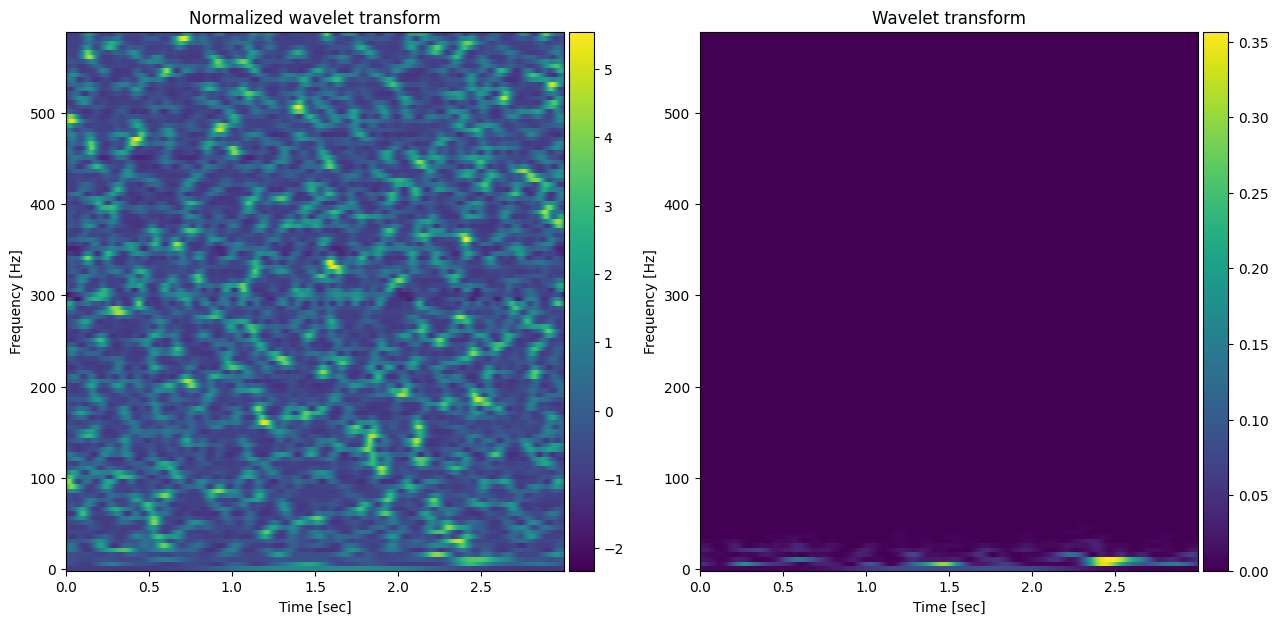

In [57]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
print(tfDB.shape)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
im1 = ax[0].pcolormesh(np.arange(nData)/srate, frex, tfDB)
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [sec]')
ax[0].set_title('Normalized wavelet transform')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[1].pcolormesh(np.arange(nData)/srate, frex, tf)
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
ax[1].set_title('Wavelet transform')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
col = fig.colorbar(im2, cax=cax, orientation='vertical')
plt.show()

In [77]:
# Test resize
tf = transforms.Resize((100, 100))
spectro = np.expand_dims(tfDB, axis=0)
spectro = torch.from_numpy(spectro)

In [78]:
spectro_resized = tf(spectro)
spectro_resized.shape

torch.Size([1, 100, 100])

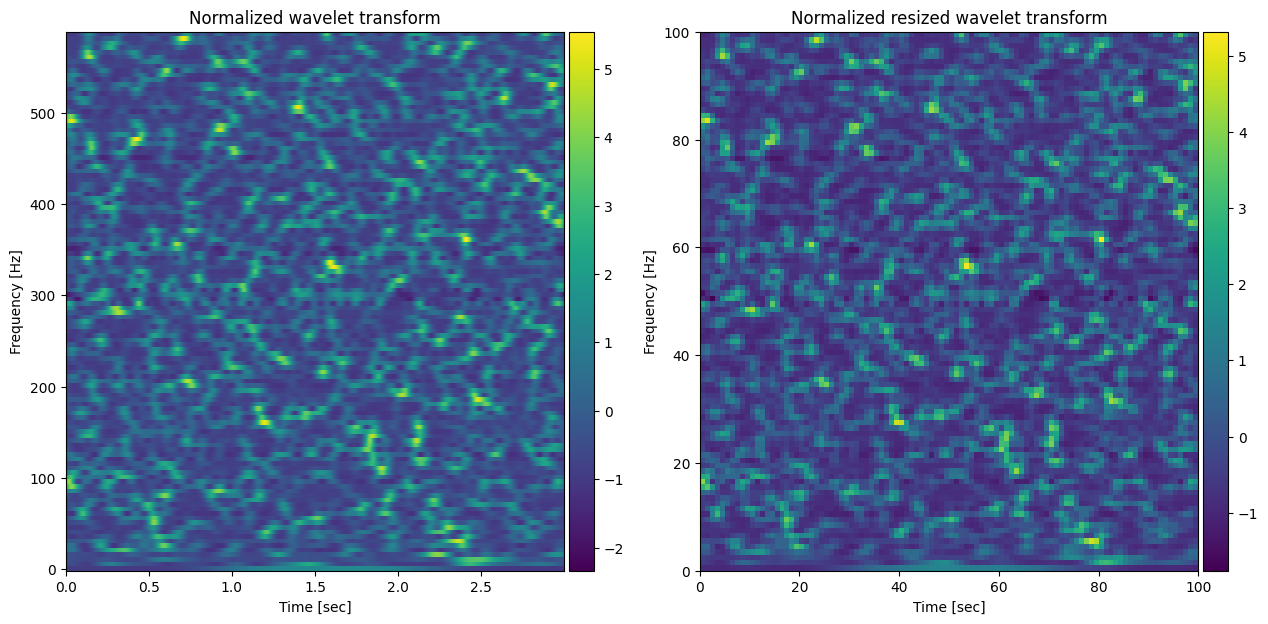

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
im1 = ax[0].pcolormesh(np.arange(nData)/srate, frex, tfDB)
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [sec]')
ax[0].set_title('Normalized wavelet transform')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[1].pcolormesh(spectro_resized.numpy().squeeze())
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
ax[1].set_title('Normalized resized wavelet transform')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

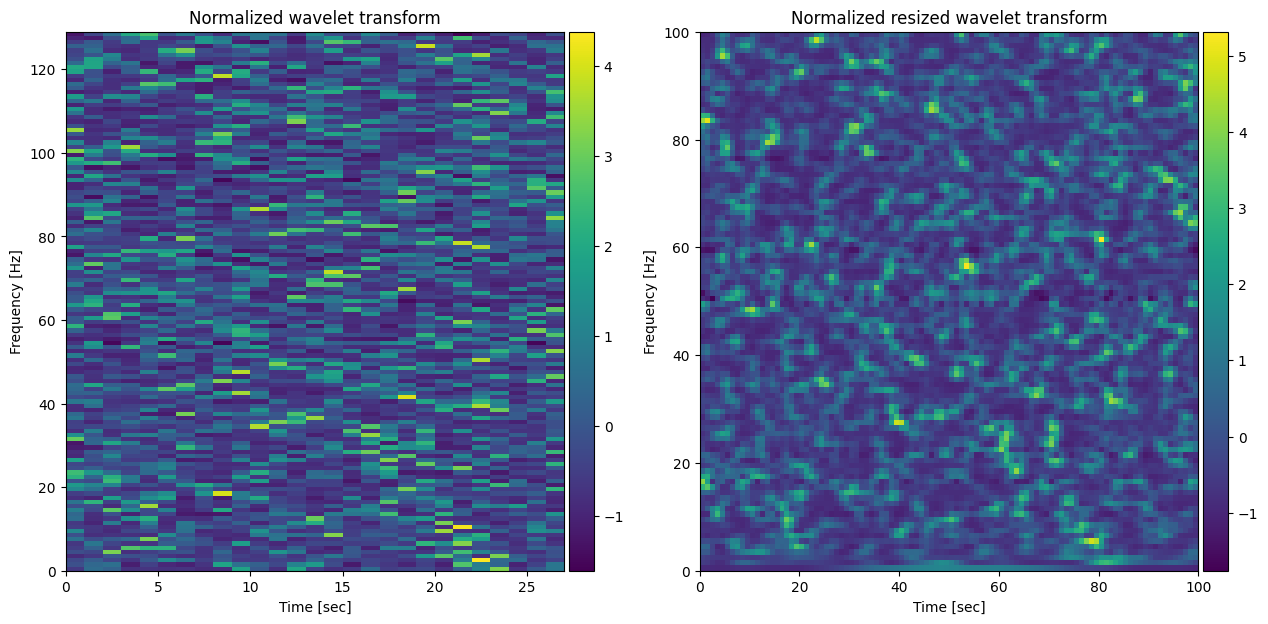

In [81]:
from scipy import stats
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
im1 = ax[0].pcolormesh(stats.zscore(data_spec.squeeze(), axis=1))
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [sec]')
ax[0].set_title('Normalized wavelet transform')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[1].pcolormesh(spectro_resized.numpy().squeeze())
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
ax[1].set_title('Normalized resized wavelet transform')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

## Test preprocessing

In [1]:
import mne

In [4]:
# Get example data
inputZip = '/home/mcesped/scratch/Datasets/Dataset_Fnusa.zip'
with zipfile.ZipFile(inputZip, mode="r") as archive:
    with archive.open('DATASET_FNUSA/y010055.mat') as myfile:
        data = scipy.io.loadmat(myfile)['data'].squeeze()

In [5]:
data.shape

(15000,)

In [8]:
np.unique(df_total.electrode_type)

array(['depth', 'strip'], dtype=object)

In [9]:
# Get data from df
df_chn = df_total.loc[df_total['segment_id']=='y010050']
df_chn

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
10050,gyrus temporalis medius,3,A'9,depth,fnusa,2,3,y010050,0,physiology


In [10]:
df_total.iloc[10002]

anatomy           gyrus temporalis medius
category_id                             3
channel                               A'8
electrode_type                      depth
institution                         fnusa
patient_id                              2
reviewer_id                             3
segment_id                        y010002
soz                                     0
category_name                  physiology
Name: 10002, dtype: object

In [11]:
df_total.iloc[10000]['electrode_type']

'depth'

In [12]:
chn_name = df_chn['channel'].tolist()
# To get channel type, map to mne names
types_map = {
    'depth': 'seeg',
    'strip': 'ecog'
}
type_chn = [types_map[df_chn['electrode_type'].tolist()[0]]]
srate = len(data)/3
# Create info
info = mne.create_info(chn_name, ch_types=type_chn, sfreq=srate)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: A'9
 chs: 1 sEEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 2500.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 5000.0 Hz
>


Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...     3.000 secs
Ready.
Using matplotlib as 2D backend.


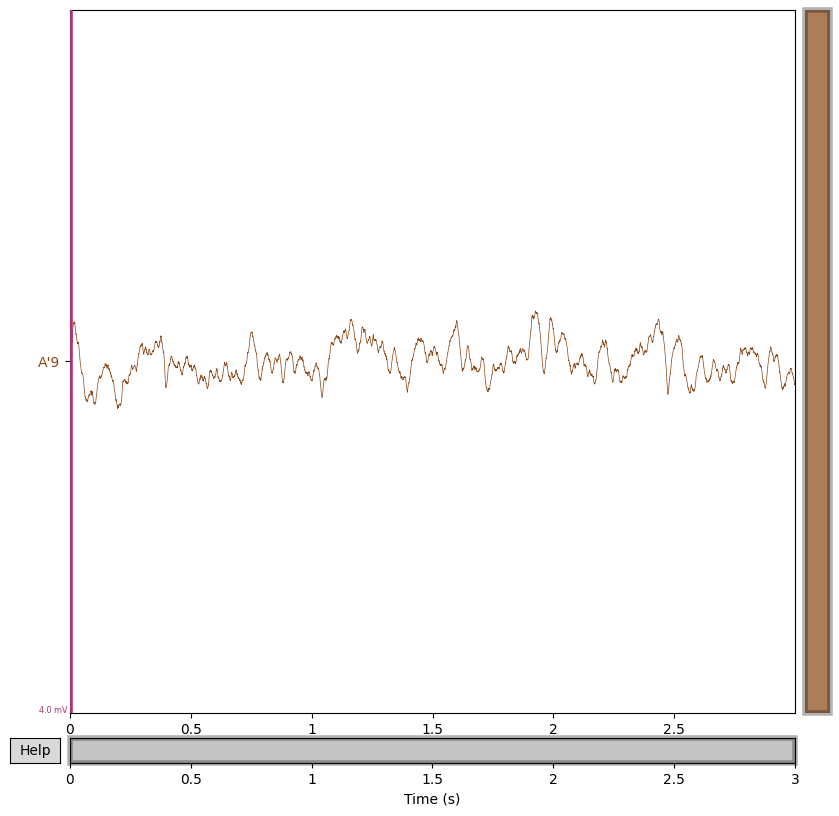

In [13]:
# Create raw
raw = mne.io.RawArray(data.reshape(1,-1)/10000, info)
_ = raw.plot(scalings={'seeg':2000e-6})

Setting up low-pass filter at 9e+02 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 6 (effective, after forward-backward)
- Cutoff at 900.00 Hz: -6.02 dB



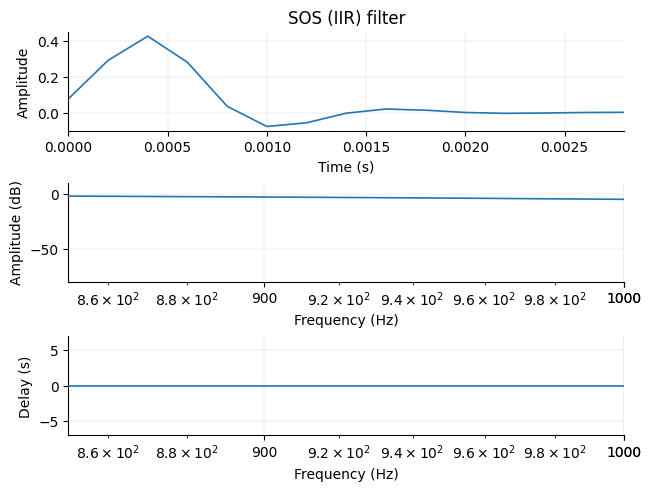

In [34]:
# High pass filter
filter_params = mne.filter.create_filter(
    raw.get_data(), raw.info["sfreq"], l_freq=None, h_freq=900, method='iir', iir_params={'order':3, 'ftype':'butter'}
)
_ = mne.viz.plot_filter(filter_params, raw.info["sfreq"], flim=(850, 1000))

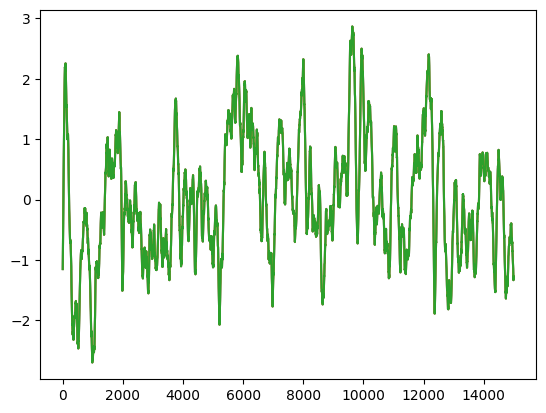

In [82]:
%matplotlib inline
plt.plot(data)
plt.show()

In [99]:
raw_highpass = raw.copy().filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 165001 samples (33.000 s)



/tmp/ipykernel_15966/3447631311.py:1: RuntimeWarning: filter_length (165001) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  raw_highpass = raw.copy().filter(l_freq=0.1, h_freq=None)


In [93]:
raw.get_data().shape

(1, 15000)

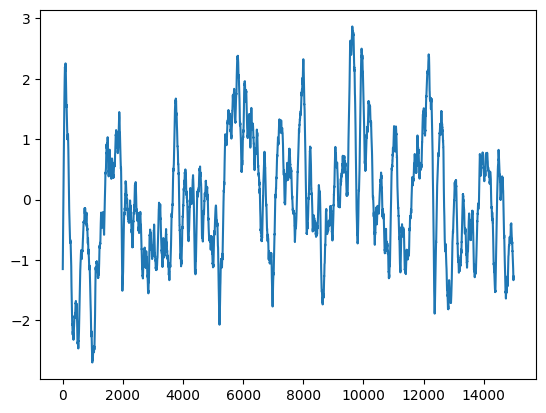

In [97]:
plt.plot(raw.get_data().squeeze()*10000)
plt.show()

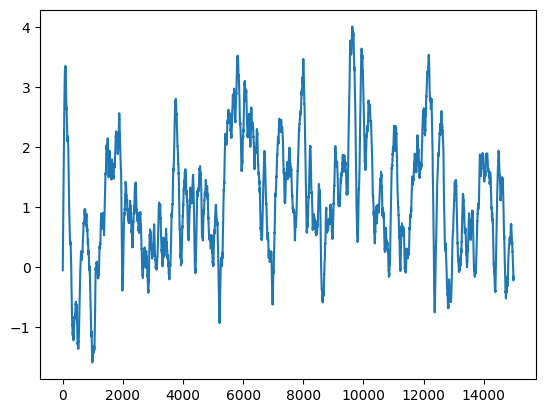

In [100]:
plt.plot(raw_highpass.get_data().squeeze()*10000)
plt.show()